![HSV-AI Logo](https://hsv.ai/wp-content/uploads/2022/03/logo_v11_2022.png)

# Reporting


In [1]:
%reload_kedro

2022-04-16 14:02:51,470 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-04-16 14:02:51,503 - kedro.config.config - INFO - Config from path `/home/jlangley/git/product-recommendation/conf/bakery` will override the following existing top-level config keys: alpha, factors, filter_value, iterations, maximum_order_size, minimum_order_size, regularization, seed, test_size, wandb_project
2022-04-16 14:02:51,505 - root - INFO - ** Kedro project productrec
2022-04-16 14:02:51,506 - root - INFO - Defined global variable `context`, `session` and `catalog`
2022-04-16 14:02:51,519 - root - INFO - Registered line magic `run_viz`


/home/jlangley/miniconda3/envs/product/lib/python3.8/site-packages/kedro/framework/context/context.py:488: UserWarning: Credentials not found in your Kedro project config.
No files found in ['/home/jlangley/git/product-recommendation/conf/base', '/home/jlangley/git/product-recommendation/conf/bakery'] matching the glob pattern(s): ['credentials*', 'credentials*/**', '**/credentials*']
  warn(f"Credentials not found in your Kedro project config.\n{str(exc)}")


In [2]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import implicit
import scipy
from sklearn import metrics
from pandas.api.types import CategoricalDtype


# Available Files

Let's go ahead and look into some of these files and see what we can see.

In [3]:
transactions = catalog.load("transactions")
products_df = catalog.load("products")

2022-04-16 14:02:53,496 - kedro.io.data_catalog - INFO - Loading data from `transactions` (CSVDataSet)...
2022-04-16 14:02:53,516 - kedro.io.data_catalog - INFO - Loading data from `products` (CSVDataSet)...


In [4]:
from IPython.display import Markdown as md

order_count = len(pd.unique(transactions['order_id']))
customer_count = len(pd.unique(transactions['customer_id']))
product_count = len(pd.unique(transactions["product_id"]))

md(
'''
# Overall Data Report

The data consists of:
* {} orders
* {} customers
* {} products
* {} purchases

'''.format(order_count, customer_count, product_count, len(transactions)))



# Overall Data Report

The data consists of:
* 9531 orders
* 1 customers
* 95 products
* 21293 purchases



In [5]:
output = '''
# Top 5 customers based on product count purchased:

'''

user_counts = transactions[transactions['customer_id'] > 0].groupby(transactions.customer_id)['product_id'].count().sort_values(ascending=False)

user_counts.head()

five_total = 0
for index, row in user_counts[:5].iteritems():
    five_total += row

table_str = user_counts[:5].to_markdown()

output += table_str

output += '''

Other customers purchased {:,} items.

'''.format(len(transactions) - five_total)

md(output)


TypeError: '>' not supported between instances of 'str' and 'int'

In [6]:
df = user_counts[:10].reset_index().rename(columns={"customer_id":"Customer", "product_id":"Purchases"})

print(type(df))
print(df)

NameError: name 'user_counts' is not defined

In [7]:
output = '''
# Top 5 customers based on total orders:

'''

user_counts = transactions[transactions['customer_id'] > 0] \
    .drop_duplicates(['customer_id', 'order_id']) \
    .groupby('customer_id')['order_id'] \
    .count() \
    .sort_values(ascending=False)

five_total = 0
for index, row in user_counts[:5].iteritems():
    print(index)
    five_total += row

table_str = user_counts[:5].to_markdown()

output += table_str

output += '''

Other customers placed {:,} orders.

'''.format(order_count - five_total)

md(output)


TypeError: '>' not supported between instances of 'str' and 'int'

In [8]:
subplot = user_counts[:5].plot.pie(autopct=lambda p: '{:.0f}'.format(p * five_total / 100), shadow=True, figsize=(11, 6))

subplot.get_figure().gca().set_ylabel("")
subplot.get_figure().gca().set_xlabel("")
subplot.get_figure().gca().set_title("Comparison of top 5 customers")

plt.show()


NameError: name 'user_counts' is not defined

In [9]:
temp = (100. * user_counts / user_counts.sum()).sort_values(ascending=False)

count = 0
total = 0
buckets=[]
for val in temp:
    
    if total + val > 25:
        buckets.append(count)
        total = 0
        count = 0
        
    count+=1
    total+=val

print(buckets)
labels = ['Top 25%', '2nd 25%', '3rd 25%', '4th 25%']
fig1, ax1 = plt.subplots(figsize=(10, 8))
plt.pie(buckets, labels=labels, autopct=lambda p: '{:.0f}'.format(p * len(temp) / 100))
fig1.gca().set_title("Breakdown of customers by order count")
plt.show()

NameError: name 'user_counts' is not defined

In [10]:
output = '''
# Top 5 products based on total count purchased:

'''

product_counts = transactions.groupby(transactions.product_id)['quantity'].agg('sum').sort_values(ascending=False)

product_counts.head()

five_total = 0
for index, row in product_counts[:5].iteritems():
    five_total += row

table_str = product_counts[:5].to_markdown()

output += table_str

output += '''

Other products purchased {:,} times.

'''.format(transactions['quantity'].sum() - five_total)

md(output)



# Top 5 products based on total count purchased:

| product_id   |   quantity |
|:-------------|-----------:|
| Coffee       |       5471 |
| Bread        |       3325 |
| Tea          |       1435 |
| Cake         |       1025 |
| Pastry       |        856 |

Other products purchased 9,181 times.



In [11]:
product_counts = transactions \
    .groupby(transactions.product_id)['quantity'] \
    .agg('sum'). \
    sort_values(ascending=False)

product_df = product_counts \
    .reset_index() \
    .rename(columns={"product_id":"Product", "quantity":"Quantity"})
print(type(product_df[:10]))

product_df = product_counts \
    .reset_index() \
    .rename(columns={"product_id":"Product", "quantity":"Quantity"})
print(type(product_df[:10]))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [12]:
output = '''
# Top 5 products based on counting orders that included them:

'''

product_counts = transactions \
    .groupby('product_id')['order_id'] \
    .count() \
    .sort_values(ascending=False)

five_total = 0
for index, row in product_counts[:5].iteritems():
    five_total += row

table_str = product_counts[:5].to_markdown()

output += table_str

output += '''

Other customers placed {:,} orders.

'''.format(order_count - five_total)

md(output)



# Top 5 products based on counting orders that included them:

| product_id   |   order_id |
|:-------------|-----------:|
| Coffee       |       5471 |
| Bread        |       3325 |
| Tea          |       1435 |
| Cake         |       1025 |
| Pastry       |        856 |

Other customers placed -2,581 orders.



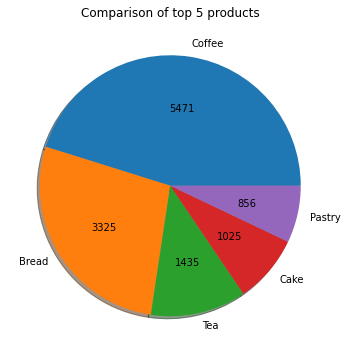

In [13]:
subplot = product_counts[:5].plot.pie(autopct=lambda p: '{:.0f}'.format(p * five_total / 100), shadow=True, figsize=(11, 6))

subplot.get_figure().gca().set_ylabel("")
subplot.get_figure().gca().set_xlabel("")
subplot.get_figure().gca().set_title("Comparison of top 5 products")

plt.show()

# plt.plot(product_counts.values) 

95
6


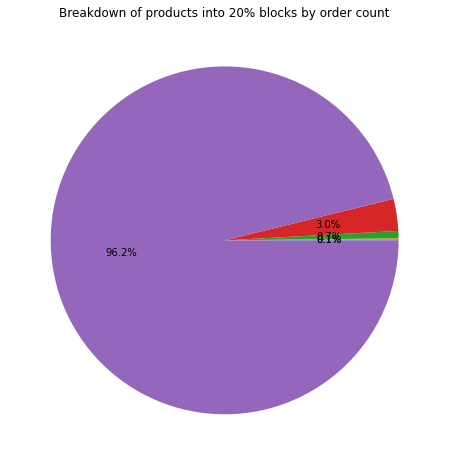

In [18]:
# print(product_counts)
quantiles, bins = pd.qcut(x=product_counts, q=5, retbins=True, duplicates='drop')

print(len(quantiles))
print(len(bins))
batches = []
batches.append(bins[1])
for i in range(2,len(bins)):
    batches.append(bins[i] - bins[i-1])
    
labels = ["Bottom 20%", "4th", "3rd", "4th", "Top 20%"]
fig1, ax1 = plt.subplots(figsize=(10, 8))
plt.pie(batches, autopct='%1.1f%%')

fig1.gca().set_title("Breakdown of products into 20% blocks by order count")
    
# ax.set_yticks(jobs)
# ax.set_xlabel('Hour')
# ax.set_title('Run Time by Job')
# ax.grid(True)
# ax.legend()
# plt.tight_layout()
#plt.savefig('C:\\Data\\stackedbar.png')
plt.show()

In [ ]:
counts = pd.qcut(product_counts, [0, .25, .5, .75, 1]).value_counts(sort=False)
print(counts)
print(len(product_counts))

In [ ]:
quantiles = np.quantile(product_counts, [0.25, 0.5, 0.75, 1.0])

print(quantiles)

temp = (100. * product_counts / product_counts.sum()).sort_values(ascending=False)

# count = 0
# total = 0
# buckets=[]
# for val in temp:
    
#     if total + val > 25:
#         buckets.append(count)
#         total = 0
#         count = 0
        
#     count+=1
#     total+=val

# print(buckets)
# labels = ['Top 25%', '2nd 25%', '3rd 25%', '4th 25%']
# fig1, ax1 = plt.subplots(figsize=(10, 8))
# plt.pie(buckets, labels=labels, autopct=lambda p: '{:.0f}'.format(p * len(temp) / 100))
# fig1.gca().set_title("Breakdown of products by order count")
# plt.show()

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

grouped = transactions.groupby('order_id').agg({"product_id": lambda x: list(x)})
temp = grouped['product_id'].values


In [ ]:
te = TransactionEncoder()

oht_ary = te.fit(temp).transform(temp, sparse=True)
sparse_df = pd.DataFrame.sparse.from_spmatrix(oht_ary, columns=te.columns_)
sparse_df.columns = [str(i) for i in sparse_df.columns]
top_sets = apriori(sparse_df, min_support=0.012, use_colnames=True, verbose=1, max_len=5)
top_sets['length'] = top_sets['itemsets'].apply(lambda x: len(x))

In [ ]:
set1 = top_sets[top_sets['length'] == 1].sort_values('support', ascending=False).reset_index()[:5]['itemsets']

print(set1)


In [ ]:
set2 = top_sets[top_sets['length'] == 2].sort_values('support', ascending=False).reset_index()[:5]

print(set2)

In [ ]:
set3 = top_sets[top_sets['length'] == 3].sort_values('support', ascending=False).reset_index()[:5]
print(set3)

In [ ]:
set4 = top_sets[top_sets['length'] == 4].sort_values('support', ascending=False).reset_index()[:5]
print(set4)

In [ ]:
set5 = top_sets[top_sets['length'] == 5].sort_values('support', ascending=False).reset_index()[:5]
print(set5)